### Download materias for a sample senator

In [47]:
import csv
import re
import sys
import matplotlib.pyplot as plt

TAG_RE = re.compile(r'<[^>]+>')
SPACE_RE = re.compile('&nbsp;')

def attr(valueDict, attrPath, defaultValue=''):
    if type(valueDict) != dict:
        raise 'valueDict must be dict type'
    parts = attrPath.split('.')
    cv = valueDict
    for p in parts:
        cv = cv.get(p)
        if cv == None:
            return defaultValue
    return cv

In [80]:
import requests

SENATOR_NAME = 'Cristovam'
MAX = 100

headers = {'Accept': 'application/json'}
res = requests.get('http://legis.senado.leg.br/dadosabertos/materia/pesquisa/lista?sigla=pls&nomeAutor=' + SENATOR_NAME, headers=headers)
# res = requests.get('http://legis.senado.leg.br/dadosabertos/materia/pesquisa/lista?nomeAutor=' + SENATOR_NAME, headers=headers)
contents = res.json()

materias = contents['PesquisaBasicaMateria']['Materias']['Materia']

print("Downloading materias")
i = 0
alltexts = ''
with open("output/senator-materias.csv", "w", encoding='utf-8') as ofile:
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    print('Found ' + str(len(materias)) + ' materias')
    for mat in materias:
        i = i + 1
#         try:
        codigoMateria = mat['IdentificacaoMateria']['CodigoMateria']
#         print("Getting relatorias for materia " + str(codigoMateria))
        res = requests.get('http://legis.senado.leg.br/dadosabertos/materia/relatorias/' + str(codigoMateria), headers=headers)
        rel = res.json()
        codigosRelatores = ''
        if 'HistoricoRelatoria' in rel['RelatoriaMateria']['Materia']:
            relatores = rel['RelatoriaMateria']['Materia']['HistoricoRelatoria']['Relator']
            if type(relatores) == dict:
                cr = r['IdentificacaoParlamentar']['CodigoParlamentar']
#                 print('Found relator ' + str(cr))
                codigosRelatores = str(cr)
            else:
                for r in relatores:
                    cr = r['IdentificacaoParlamentar']['CodigoParlamentar']
#                     print('Found relator ' + str(cr))
                    codigosRelatores = codigosRelatores + str(cr) + ' '

        #fields codigoMateria, data, casa, tipoMateria, naturezaMateria, codigoAutor, nomeAutor, partidoAutor, 
        #ufAutor, sexoAutor, ementa, explicacaoEmenta, indexacaoMateria, situacao, relatores
        row = [ mat['IdentificacaoMateria']['CodigoMateria'],
                mat['DadosBasicosMateria']['DataApresentacao'],
                mat['IdentificacaoMateria']['SiglaCasaIdentificacaoMateria'],
                mat['IdentificacaoMateria']['SiglaSubtipoMateria'],
                attr(mat,'DadosBasicosMateria.NaturezaMateria.NomeNatureza'),
                mat['AutoresPrincipais']['AutorPrincipal']['IdentificacaoParlamentar']['CodigoParlamentar'],
                mat['AutoresPrincipais']['AutorPrincipal']['IdentificacaoParlamentar']['NomeParlamentar'],
                mat['AutoresPrincipais']['AutorPrincipal']['IdentificacaoParlamentar']['SiglaPartidoParlamentar'],
                mat['AutoresPrincipais']['AutorPrincipal']['IdentificacaoParlamentar']['UfParlamentar'],
                mat['AutoresPrincipais']['AutorPrincipal']['IdentificacaoParlamentar']['SexoParlamentar'],
                attr(mat,'DadosBasicosMateria.EmentaMateria'),
                attr(mat,'DadosBasicosMateria.ExplicacaoEmentaMateria'),
                attr(mat,'DadosBasicosMateria.IndexacaoMateria'),
                mat['SituacaoAtual']['Autuacoes']['Autuacao']['Situacao']['SiglaSituacao'],
                codigosRelatores,
              ]
        writer.writerow(row)
#         print(row)
        alltexts = alltexts + '\n' + attr(mat,'DadosBasicosMateria.EmentaMateria') + ' ' + attr(mat,'DadosBasicosMateria.ExplicacaoEmentaMateria') + ' ' + attr(mat,'DadosBasicosMateria.IndexacaoMateria') + ' ' + attr(mat,'DadosBasicosMateria.NaturezaMateria.NomeNatureza')
        sys.stdout.write('.')
        if i > MAX:
            break
#         except:
#             if i > MAX:
#                 break

print("Done")

Found 168 materias
.....................................................................................................Done


### Word cloud

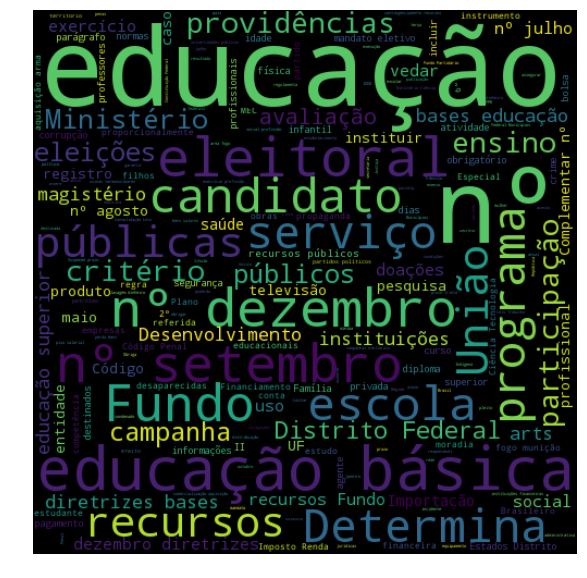

In [81]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8'))
# print(stopwords)

# Generate a word cloud image
wc = WordCloud(background_color="black", max_words=200,
               stopwords=stopwords, max_font_size=100, random_state=42,
               width=500, height=500)

wordcloud = wc.generate(alltexts)
plt.figure(figsize=(20,10))
# plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()